<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Covid_python_with_apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Trends Prediction in Thailand Using Time Series Neural Networks

---


We used convolutional neural network (CNN), recurrent neural networks (RNNs), gated recurrent unit (GRU) and long short-term memory (LSTM) to predict Covid-19 cases and deaths in Thailand, using 14 previous days as samples to predict the next 1 day. These models particularly deal with time series data. Further, we ran multivariate neural networks with policy implementations, mobility changes, transportation behavior changes, vaccination, confirmed cases (for predicting deaths) and confirmed deaths (for predicting cases) as additional predictors. Our goal was to minimize the mean average percentage error (MAPE) between the actual values and predictions.  



## Data Sources


The Covid-19 data was from https://github.com/CSSEGISandData/COVID-19 by John Hopkins University. The data included both confirmed infects and confirmed deaths reported by Thailand’s Ministry of Public Health. 
Policy implementation in Thailand data was gathered by Oxford Covid-19 Government Response Tracker (OxCGRT) (https://github.com/OxCGRT/covid-policy-tracker). This policy record indicated when and how the government in each country responded to the pandemic at specific time periods. We used containment and health index which consisted of school closing, workplace closing, canceling public events, restrictions on gatherings, close public transport, stay at home requirements, international travel controls, and public information campaign. Each indicator was coded in different levels of implementations (see more: ​​https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md)
The mobility data was from Google (https://www.google.com/covid19/mobility). Google calculated the changes of mobility based on Location History of users on Google Map. The baseline of the changes was the median value from January, 3rd to February 6th, 2020. There were four categories: groceries and pharmacy, retail and recreation, transit stations, and finally, parks. Another source of mobility was from Apple where it tracked wkiving and walking behaviors during the pandemic (https://covid19.apple.com/mobility). 
Vaccination count was gathered from Thailand’s Ministry of Health (https://github.com/porames/the-researcher-covid-data?fbclid=IwAR1-SAiA8pMKD5qbcN7S5c-p_snBIIWd42wYOq4qiM9yA6FTf_GcyYgxtvA). This vaccination information that was used in this study was the amount of Thai people who received their first shot, second shot of vaccines, regardless of the vaccine types. 
Finally, the last input data was transportation behavior from Thai’s Ministry of Transportation (https://datagov.mot.go.th/dataset/covid-19/resource/71a552d0-0fea-4e05-b78c-42d58aa88db6?fbclid=IwAR18p4TQY3qlD9snnhADdvrAWVjOgofse54GbNKm8Qb-pMgBb-ZejebWD-w). The information included the rate of use for both public and private transportation systems in Thailand. 



## Import packages

In [1]:
!pip install -U tensorflow-addons
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization
from keras.layers import LayerNormalization
from keras.layers import Flatten
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
data = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

data = pd.DataFrame(data)

# select Thailand only
data = data.loc[data['CountryName'] == "Thailand"]

# select columns
data = data[["Date","ConfirmedCases", "ConfirmedDeaths"]]

# change date format
data.Date =  pd.to_datetime(data["Date"], format='%Y%m%d')

# reset index
data = data.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["ConfirmedCases", "ConfirmedDeaths"]] = data[["ConfirmedCases", "ConfirmedDeaths"]].replace(np.nan, 0)

# remove NaN rows (bottom part)
data = data.dropna()

# add daily cases columns
data[["Cases_daily"]] = data['ConfirmedCases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
data[["Deaths_daily"]] = data['ConfirmedDeaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# replace NaN with 0 for ConfirmedCases and Deaths_daily
data[["Cases_daily", "Deaths_daily"]] = data[["Cases_daily", "Deaths_daily"]].replace(np.nan, 0)


# start from 15/2/2020
data = data[data.loc[data['Date'] == "2020-02-15"].index[0]:]

# remove the last rows with incomplete info
data = data.loc[~(data[["ConfirmedCases"]]==0).all(axis=1)]


# reset index
data = data.reset_index(drop = True)



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
apple = read_csv("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/apple_reports/applemobilitytrends.csv")

apple = pd.DataFrame(apple)

apple = apple.loc[apple['region'] == "Thailand"]

apple = apple.T

# select rows
apple = apple.drop(apple.index[[0,1,2,3,4,5]], axis= 0)

apple["Date"] = pd.to_datetime(apple.index)

# change column names
apple = apple.rename(columns= {135:"Driving", 136:"Walking"})

apple['Driving'] = apple['Driving'].astype(float, errors = 'raise')
apple['Walking'] = apple['Walking'].astype(float, errors = 'raise')

# start from 15/2/2020
apple = apple[apple.loc[apple['Date'] == "2020-02-15"].index[0]:]

apple = apple.reset_index(drop=True)

# omit Date column
apple0 = apple.drop(["Date"], axis = 1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.



In [4]:
# whichever has fewer data
length = min(len(data), len(apple))

# Cases daily
data_i = pd.concat([data.Cases_daily[:length], 
                    data.Date[:length],
                    apple0[:length]], axis = 1)

data_i = data_i.rename(columns = {"Cases_daily":"data_i"})
data_i = data_i[data_i.loc[data_i['Date'] == "2021-06-15"].index[0]:]

# drop date column
data_i = data_i.drop(["Date"], axis = 1)

# Deaths daily
data_d = pd.concat([data.Deaths_daily[:length], 
                    data.Date[:length],
                    apple0[:length]], axis = 1)

data_d = data_d.rename(columns = {"Deaths_daily":"data_d"})
data_d = data_d[data_d.loc[data_d['Date'] == "2021-06-15"].index[0]:]

# drop date column
data_d = data_d.drop(["Date"], axis = 1)

In [5]:
case = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

case = pd.DataFrame(case)

# select Thailand only
case = case.loc[case['CountryName'] == "Thailand"]

case = case[["Date", "ConfirmedCases", "ConfirmedDeaths"]]

# change date format
case.Date =  pd.to_datetime(case["Date"], format='%Y%m%d')

# reset index
case = case.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
case[["ConfirmedCases", "ConfirmedDeaths"]] = case[["ConfirmedCases", "ConfirmedDeaths"]].replace(np.nan, 0)

# add daily cases columns
case[["Cases_daily"]] = case['ConfirmedCases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
case[["Deaths_daily"]] = case['ConfirmedDeaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# replace NaN with 0 for ConfirmedCases and Deaths_daily
case[["Cases_daily", "Deaths_daily"]] = case[["Cases_daily", "Deaths_daily"]].replace(np.nan, 0)

# start from 15/2/2020
case = case[case.loc[case['Date'] == "2020-02-15"].index[0]:]

# reset index
case = case.reset_index(drop = True)

# remove the last rows with incomplete info
case = case.loc[~(case[["ConfirmedCases"]]==0).all(axis=1)]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



In [6]:
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]
# apple = apple[apple.loc[apple['Date'] == "2021-06-15"].index[0]:]
actual = case[case.loc[case['Date'] == "2021-06-15"].index[0]:]


## Import data

In [7]:

# use the previous 14 days to predict the next day
lag = 14
prediction = 1
window = 3 # for moving average

# moving average
data_i['data_i'] = data_i.data_i.rolling(window).mean()
data_d['data_d'] = data_d.data_d.rolling(window).mean()

# remove NaN
data_i.dropna(subset = ["data_i"], inplace=True)
data_d.dropna(subset = ["data_d"], inplace=True)

data = data.reset_index(drop = True)
data_i = data_i.reset_index(drop = True)
data_d = data_d.reset_index(drop = True)



## Methods

---


The data was available from February 22nd, 2020 to September 9th, 2021 (as the date the data was retrieved). However, the third wave of the epidemic in Thailand started after April 1st, 2021, and the trend started to rise after June. Thus, we used the data from, June 15th to July 29th, 2021 for our training; July 30th to August 18th, 2021 for our validation, and August 19th to September 2nd, 2021 for our prediction. There were 31 samples in total for training, 20 samples for validation, and predictions of 15 days ahead. 

Since confirmed cases, confirmed deaths and vaccination data were given in cumulative counts, we computed the daily cases, deaths and vaccination to match the format of other predictors: mobility and transportation changes. Neural networks required input and output in forms of matrices. The experiments consisted of univariate and multivariate approaches for training, validation, and prediction

For the univariate, we created an input matrix with 14 columns as the previous 14 days input. The number of rows was equal to total samples - 14 days - 1-day prediction + 1 or 31 rows. To demonstrate, the first row would have the 1st to the 14th day. The second row would have the 2nd to the 15th day, and so forth as a rolling window. The output matrix would be the 1 column for 1-day prediction with the same amount of rows as the input matrix. For example, the first row would be the 15th day for the 1-day prediction. Since the neural networks could only work with at least 2 dimensions, we transformed both input and output matrices into 3 dimensions (with 1 as the third dimension).

## Data Preprocessing: Multivariate

In [8]:
def split_sequence(sequence, lag):
  x, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + lag
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    x.append(seq_x)
    y.append(seq_y)
  return array(x), array(y)

index = 30


In [9]:
# confirmed cases
nrow_total = data_i.shape[0] - lag - prediction + 1


y_i = np.array([data_i.data_i[lag:data_i.shape[0]]])
y_i = y_i.T # transpose the matrix

# split into training and test sets
# Driving
input_list = [np.expand_dims(data_i[i:lag+i][["data_i", "Driving"]], axis=0) for i in range(nrow_total)] 
X_i = np.concatenate(input_list, axis=0)
X_i_tr_dr = X_i[0:index+1, :, :]
X_i_ts_dr = X_i[index+1:data_i.shape[0], :, :]


# Walking
input_list = [np.expand_dims(data_i[i:lag+i][["data_i", "Walking"]], axis=0) for i in range(nrow_total)] 
X_i = np.concatenate(input_list, axis=0)
X_i_tr_wk = X_i[0:index+1, :, :]
X_i_ts_wk = X_i[index+1:data_i.shape[0], :, :]


y_i_tr = y_i[0:index+1]
y_i_ts = y_i[index+1:data_i.shape[0]]

# confirmed deaths
nrow_total = data_d.shape[0] - lag - prediction + 1


y_d = np.array([data_d.data_d[lag:data_d.shape[0]]])
y_d = y_d.T # transpose the matrix


# split into training and test sets
# Driving
input_list = [np.expand_dims(data_d[i:lag+i][["data_d", "Driving"]], axis=0) for i in range(nrow_total)] 
X_d = np.concatenate(input_list, axis=0)
X_d_tr_dr = X_d[0:index+1, :, :]
X_d_ts_dr = X_d[index+1:data_d.shape[0], :, :]


# Walking
input_list = [np.expand_dims(data_d[i:lag+i][["data_d", "Walking"]], axis=0) for i in range(nrow_total)] 
X_d = np.concatenate(input_list, axis=0)
X_d_tr_wk = X_d[0:index+1, :, :]
X_d_ts_wk = X_d[index+1:data_d.shape[0], :, :]


y_d_tr = y_d[0:index+1]
y_d_ts = y_d[index+1:data_d.shape[0]]


## Analysis: Driving

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [ ]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 


In [ ]:
# Multivariate CNN confirmed cases

kernel = [3, 5, 7]
pool = [2]
cnn_i_multi_dr = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_i_tr_dr, y_i_tr)
    cnn_i_multi_dr.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr_dr, y_i_tr)
    cnn_i_multi_dr.append(score)

cnn_i_multi_dr = pd.DataFrame(cnn_i_multi_dr).T
cnn_i_multi_dr.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 5.251
filter = 4, kernel size = 3, pooling size = 2: 4.807
filter = 8, kernel size = 3, pooling size = 2: 5.433
filter = 16, kernel size = 3, pooling size = 2: 3.949
filter = 32, kernel size = 3, pooling size = 2: 3.995
filter = 64, kernel size = 3, pooling size = 2: 3.663
filter = 128, kernel size = 3, pooling size = 2: 3.882
filter = 256, kernel size = 3, pooling size = 2: 4.198
filter = 512, kernel size = 3, pooling size = 2: 5.362
filter = 1024, kernel size = 3, pooling size = 2: 5.690
filter = 2, kernel size = 5, pooling size = 2: 5.290
filter = 4, kernel size = 5, pooling size = 2: 4.533
filter = 8, kernel size = 5, pooling size = 2: 5.092
filter = 16, kernel size = 5, pooling size = 2: 4.969
filter = 32, kernel size = 5, pooling size = 2: 3.999
filter = 64, kernel size = 5, pooling size = 2: 4.170
filter = 128, kernel size = 5, pooling size = 2: 3.857
filter = 256, kernel size = 5, pooling size = 2: 3.956
filter = 512, kernel size =

In [ ]:
# Multivariate CNN confirmed deaths

pool = [2]
cnn_d_multi_dr = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_dr, y_d_tr)
    cnn_d_multi_dr.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_dr, y_d_tr)
    cnn_d_multi_dr.append(score)

cnn_d_multi_dr = pd.DataFrame(cnn_d_multi_dr).T
cnn_d_multi_dr.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 11.633
filter = 4, kernel size = 3, pooling size = 2: 11.016
filter = 8, kernel size = 3, pooling size = 2: 8.797
filter = 16, kernel size = 3, pooling size = 2: 8.617
filter = 32, kernel size = 3, pooling size = 2: 7.112
filter = 64, kernel size = 3, pooling size = 2: 6.176
filter = 128, kernel size = 3, pooling size = 2: 5.640
filter = 256, kernel size = 3, pooling size = 2: 5.278
filter = 512, kernel size = 3, pooling size = 2: 4.558
filter = 1024, kernel size = 3, pooling size = 2: 4.288
filter = 2, kernel size = 5, pooling size = 2: 9.935
filter = 4, kernel size = 5, pooling size = 2: 9.676
filter = 8, kernel size = 5, pooling size = 2: 7.101
filter = 16, kernel size = 5, pooling size = 2: 7.800
filter = 32, kernel size = 5, pooling size = 2: 6.750
filter = 64, kernel size = 5, pooling size = 2: 7.848
filter = 128, kernel size = 5, pooling size = 2: 6.749
filter = 256, kernel size = 5, pooling size = 2: 6.133
filter = 512, kernel size

### LSTM

In [ ]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

units = [2, 4,8,16,32,64,128,256,512, 1024]

# Multivariate LSTM confirmed cases

lstm_i_multi_dr = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_tr_dr, y_i_tr, i)
  lstm_i_multi_dr.append(score)



# Multivariate LSTM confirmed deaths

lstm_d_multi_dr = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_tr_dr, y_d_tr, i)
  lstm_d_multi_dr.append(score)

### GRU

In [ ]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# Multivariate GRU confirmed cases

gru_i_multi_dr = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_tr_dr, y_i_tr, i)
  gru_i_multi_dr.append(score)


# Multivariate GRU confirmed deaths

gru_d_multi_dr = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_tr_dr, y_d_tr, i)
  gru_d_multi_dr.append(score)

### RNNs

In [ ]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate RNNs confirmed cases

rnn_i_multi_dr = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_tr_dr, y_i_tr, i)
  rnn_i_multi_dr.append(score)


# Multivariate RNNs confirmed deaths

rnn_d_multi_dr = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_tr_dr, y_d_tr, i)
  rnn_d_multi_dr.append(score)

### Result Table

#### Multivariate Confirmed Cases

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', 
                                                   '32 Nodes', "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_multi_dr[0],3), 
                                     round(gru_i_multi_dr[0],3),
                                     round(rnn_i_multi_dr[0],3), 
                                     round(cnn_i_multi_dr.iloc[0,0],3),
                                     round(cnn_i_multi_dr.iloc[0,1],3),
                                     round(cnn_i_multi_dr.iloc[0,2],3),
                                     round(cnn_i_multi_dr.iloc[0,3],3),
                                     round(cnn_i_multi_dr.iloc[0,4],3),
                                     round(cnn_i_multi_dr.iloc[0,5],3)],
                                     [round(lstm_i_multi_dr[1],3), 
                                     round(gru_i_multi_dr[1],3),
                                     round(rnn_i_multi_dr[1],3), 
                                     round(cnn_i_multi_dr.iloc[1,0],3),
                                     round(cnn_i_multi_dr.iloc[1,1],3),
                                     round(cnn_i_multi_dr.iloc[1,2],3),
                                     round(cnn_i_multi_dr.iloc[1,3],3),
                                     round(cnn_i_multi_dr.iloc[1,4],3),
                                     round(cnn_i_multi_dr.iloc[1,5],3)],
                                     [round(lstm_i_multi_dr[2],3), 
                                     round(gru_i_multi_dr[2],3),
                                     round(rnn_i_multi_dr[2],3), 
                                     round(cnn_i_multi_dr.iloc[2,0],3),
                                     round(cnn_i_multi_dr.iloc[2,1],3),
                                     round(cnn_i_multi_dr.iloc[2,2],3),
                                     round(cnn_i_multi_dr.iloc[2,3],3),
                                     round(cnn_i_multi_dr.iloc[2,4],3),
                                     round(cnn_i_multi_dr.iloc[2,5],3)],
                                     [round(lstm_i_multi_dr[3],3), 
                                     round(gru_i_multi_dr[3],3),
                                     round(rnn_i_multi_dr[3],3), 
                                     round(cnn_i_multi_dr.iloc[3,0],3),
                                     round(cnn_i_multi_dr.iloc[3,1],3),
                                     round(cnn_i_multi_dr.iloc[3,2],3),
                                     round(cnn_i_multi_dr.iloc[3,3],3),
                                     round(cnn_i_multi_dr.iloc[3,4],3),
                                     round(cnn_i_multi_dr.iloc[3,5],3)],
                                     [round(lstm_i_multi_dr[4],3), 
                                     round(gru_i_multi_dr[4],3),
                                     round(rnn_i_multi_dr[4],3), 
                                     round(cnn_i_multi_dr.iloc[4,0],3),
                                     round(cnn_i_multi_dr.iloc[4,1],3),
                                     round(cnn_i_multi_dr.iloc[4,2],3),
                                     round(cnn_i_multi_dr.iloc[4,3],3),
                                     round(cnn_i_multi_dr.iloc[4,4],3),
                                     round(cnn_i_multi_dr.iloc[4,5],3)],
                                     [round(lstm_i_multi_dr[5],3), 
                                     round(gru_i_multi_dr[5],3),
                                     round(rnn_i_multi_dr[5],3), 
                                     round(cnn_i_multi_dr.iloc[5,0],3),
                                     round(cnn_i_multi_dr.iloc[5,1],3),
                                     round(cnn_i_multi_dr.iloc[5,2],3),
                                     round(cnn_i_multi_dr.iloc[5,3],3),
                                     round(cnn_i_multi_dr.iloc[5,4],3),
                                     round(cnn_i_multi_dr.iloc[5,5],3)],
                                     [round(lstm_i_multi_dr[6],3), 
                                     round(gru_i_multi_dr[6],3),
                                     round(rnn_i_multi_dr[6],3), 
                                     round(cnn_i_multi_dr.iloc[6,0],3),
                                     round(cnn_i_multi_dr.iloc[6,1],3),
                                     round(cnn_i_multi_dr.iloc[6,2],3),
                                     round(cnn_i_multi_dr.iloc[6,3],3),
                                     round(cnn_i_multi_dr.iloc[6,4],3),
                                     round(cnn_i_multi_dr.iloc[6,5],3)],
                                     [round(lstm_i_multi_dr[7],3), 
                                     round(gru_i_multi_dr[7],3),
                                     round(rnn_i_multi_dr[7],3), 
                                     round(cnn_i_multi_dr.iloc[7,0],3),
                                     round(cnn_i_multi_dr.iloc[7,1],3),
                                     round(cnn_i_multi_dr.iloc[7,2],3),
                                     round(cnn_i_multi_dr.iloc[7,3],3),
                                     round(cnn_i_multi_dr.iloc[7,4],3),
                                     round(cnn_i_multi_dr.iloc[7,5],3)],
                                     [round(lstm_i_multi_dr[8],3), 
                                     round(gru_i_multi_dr[8],3),
                                     round(rnn_i_multi_dr[8],3), 
                                     round(cnn_i_multi_dr.iloc[8,0],3),
                                     round(cnn_i_multi_dr.iloc[8,1],3),
                                     round(cnn_i_multi_dr.iloc[8,2],3),
                                     round(cnn_i_multi_dr.iloc[8,3],3),
                                     round(cnn_i_multi_dr.iloc[8,4],3),
                                     round(cnn_i_multi_dr.iloc[8,5],3)],
                                     [round(lstm_i_multi_dr[9],3), 
                                     round(gru_i_multi_dr[9],3),
                                     round(rnn_i_multi_dr[9],3), 
                                     round(cnn_i_multi_dr.iloc[9,0],3),
                                     round(cnn_i_multi_dr.iloc[9,1],3),
                                     round(cnn_i_multi_dr.iloc[9,2],3),
                                     round(cnn_i_multi_dr.iloc[9,3],3),
                                     round(cnn_i_multi_dr.iloc[9,4],3),
                                     round(cnn_i_multi_dr.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Multivariate Confirmed Deaths

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_multi_dr[0],3), 
                                     round(gru_d_multi_dr[0],3),
                                     round(rnn_d_multi_dr[0],3), 
                                     round(cnn_d_multi_dr.iloc[0,0],3),
                                     round(cnn_d_multi_dr.iloc[0,1],3),
                                     round(cnn_d_multi_dr.iloc[0,2],3),
                                     round(cnn_d_multi_dr.iloc[0,3],3),
                                     round(cnn_d_multi_dr.iloc[0,4],3),
                                     round(cnn_d_multi_dr.iloc[0,5],3)],
                                     [round(lstm_d_multi_dr[1],3), 
                                     round(gru_d_multi_dr[1],3),
                                     round(rnn_d_multi_dr[1],3), 
                                     round(cnn_d_multi_dr.iloc[1,0],3),
                                     round(cnn_d_multi_dr.iloc[1,1],3),
                                     round(cnn_d_multi_dr.iloc[1,2],3),
                                     round(cnn_d_multi_dr.iloc[1,3],3),
                                     round(cnn_d_multi_dr.iloc[1,4],3),
                                     round(cnn_d_multi_dr.iloc[1,5],3)],
                                     [round(lstm_d_multi_dr[2],3), 
                                     round(gru_d_multi_dr[2],3),
                                     round(rnn_d_multi_dr[2],3), 
                                     round(cnn_d_multi_dr.iloc[2,0],3),
                                     round(cnn_d_multi_dr.iloc[2,1],3),
                                     round(cnn_d_multi_dr.iloc[2,2],3),
                                     round(cnn_d_multi_dr.iloc[2,3],3),
                                     round(cnn_d_multi_dr.iloc[2,4],3),
                                     round(cnn_d_multi_dr.iloc[2,5],3)],
                                     [round(lstm_d_multi_dr[3],3), 
                                     round(gru_d_multi_dr[3],3),
                                     round(rnn_d_multi_dr[3],3), 
                                     round(cnn_d_multi_dr.iloc[3,0],3),
                                     round(cnn_d_multi_dr.iloc[3,1],3),
                                     round(cnn_d_multi_dr.iloc[3,2],3),
                                     round(cnn_d_multi_dr.iloc[3,3],3),
                                     round(cnn_d_multi_dr.iloc[3,4],3),
                                     round(cnn_d_multi_dr.iloc[3,5],3)],
                                     [round(lstm_d_multi_dr[4],3), 
                                     round(gru_d_multi_dr[4],3),
                                     round(rnn_d_multi_dr[4],3), 
                                     round(cnn_d_multi_dr.iloc[4,0],3),
                                     round(cnn_d_multi_dr.iloc[4,1],3),
                                     round(cnn_d_multi_dr.iloc[4,2],3),
                                     round(cnn_d_multi_dr.iloc[4,3],3),
                                     round(cnn_d_multi_dr.iloc[4,4],3),
                                     round(cnn_d_multi_dr.iloc[4,5],3)],
                                     [round(lstm_d_multi_dr[5],3), 
                                     round(gru_d_multi_dr[5],3),
                                     round(rnn_d_multi_dr[5],3), 
                                     round(cnn_d_multi_dr.iloc[5,0],3),
                                     round(cnn_d_multi_dr.iloc[5,1],3),
                                     round(cnn_d_multi_dr.iloc[5,2],3),
                                     round(cnn_d_multi_dr.iloc[5,3],3),
                                     round(cnn_d_multi_dr.iloc[5,4],3),
                                     round(cnn_d_multi_dr.iloc[5,5],3)],
                                     [round(lstm_d_multi_dr[6],3), 
                                     round(gru_d_multi_dr[6],3),
                                     round(rnn_d_multi_dr[6],3), 
                                     round(cnn_d_multi_dr.iloc[6,0],3),
                                     round(cnn_d_multi_dr.iloc[6,1],3),
                                     round(cnn_d_multi_dr.iloc[6,2],3),
                                     round(cnn_d_multi_dr.iloc[6,3],3),
                                     round(cnn_d_multi_dr.iloc[6,4],3),
                                     round(cnn_d_multi_dr.iloc[6,5],3)],
                                     [round(lstm_d_multi_dr[7],3), 
                                     round(gru_d_multi_dr[7],3),
                                     round(rnn_d_multi_dr[7],3), 
                                     round(cnn_d_multi_dr.iloc[7,0],3),
                                     round(cnn_d_multi_dr.iloc[7,1],3),
                                     round(cnn_d_multi_dr.iloc[7,2],3),
                                     round(cnn_d_multi_dr.iloc[7,3],3),
                                     round(cnn_d_multi_dr.iloc[7,4],3),
                                     round(cnn_d_multi_dr.iloc[7,5],3)],
                                     [round(lstm_d_multi_dr[8],3), 
                                     round(gru_d_multi_dr[8],3),
                                     round(rnn_d_multi_dr[8],3), 
                                     round(cnn_d_multi_dr.iloc[8,0],3),
                                     round(cnn_d_multi_dr.iloc[8,1],3),
                                     round(cnn_d_multi_dr.iloc[8,2],3),
                                     round(cnn_d_multi_dr.iloc[8,3],3),
                                     round(cnn_d_multi_dr.iloc[8,4],3),
                                     round(cnn_d_multi_dr.iloc[8,5],3)],
                                     [round(lstm_d_multi_dr[9],3), 
                                     round(gru_d_multi_dr[9],3),
                                     round(rnn_d_multi_dr[9],3), 
                                     round(cnn_d_multi_dr.iloc[9,0],3),
                                     round(cnn_d_multi_dr.iloc[9,1],3),
                                     round(cnn_d_multi_dr.iloc[9,2],3),
                                     round(cnn_d_multi_dr.iloc[9,3],3),
                                     round(cnn_d_multi_dr.iloc[9,4],3),
                                     round(cnn_d_multi_dr.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation: Driving

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Multivariate Confirmed Cases

In [10]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_dr_i = Sequential()
# model_multi_dr_i.add(Conv1D(filters = 1024, kernel_size = 5, activation='relu', input_shape=(X_i_tr.shape[1], X_i_tr.shape[2])))
# # model_multi_dr_i.add(MaxPooling1D(pool_size = 2))
# model_multi_dr_i.add(Flatten())
# # model_multi_dr_i.add(Dense(64, activation = "relu"))
# model_multi_dr_i.add(Dense(1, activation = "linear"))
# model_multi_dr_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_dr_i = Sequential()
model_multi_dr_i.add(SimpleRNN(512, activation='relu', input_shape=(X_i_tr_dr.shape[1], X_i_tr_dr.shape[2])))
# model_multi_dr_i.add(Dense(2, activation = "relu"))
model_multi_dr_i.add(Dense(1, activation = "linear"))
model_multi_dr_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_dr_i.fit(X_i_tr_dr, y_i_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


scores_multi_dr_i1 = model_multi_dr_i.evaluate(X_i_tr_dr, y_i_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_dr_i1[1])

scores_multi_dr_i = model_multi_dr_i.evaluate(X_i_ts_dr, y_i_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_dr_i[1])

MAPE: training =  2.84519624710083
MAPE: test =  7.040849208831787


In [11]:
# make a prediction
# training set
y_multi_dr_i_tr = pd.DataFrame(model_multi_dr_i.predict(X_i_tr_dr))

# test set
y_multi_dr_i_ts = pd.DataFrame(model_multi_dr_i.predict(X_i_ts_dr))

# combine training and test predictions
y_multi_dr_i_total = pd.concat([y_multi_dr_i_tr, y_multi_dr_i_ts], ignore_index=True)


### Multivariate Confirmed Deaths

In [12]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_dr_d = Sequential()
# model_multi_dr_d.add(GRU(32, activation = 'relu', input_shape=(X_d_tr_dr.shape[1], X_d_tr_dr.shape[2])))
# # model_multi_dr_d.add(Dense(4, activation = "relu"))
# model_multi_dr_d.add(Dense(1, activation = "linear"))
# model_multi_dr_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_dr_d = Sequential()
model_multi_dr_d.add(Conv1D(1024, kernel_size = 3, activation = 'relu', input_shape=(X_d_tr_dr.shape[1], X_d_tr_dr.shape[2])))
model_multi_dr_d.add(MaxPooling1D(3))
model_multi_dr_d.add(Flatten())
# model_multi_dr_d.add(Dense(2, activation = "relu"))
model_multi_dr_d.add(Dense(1, activation = "linear"))
model_multi_dr_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_dr_d.fit(X_d_tr_dr, y_d_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_dr_d1 = model_multi_dr_d.evaluate(X_d_tr_dr, y_d_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_dr_d1[1])

scores_multi_dr_d = model_multi_dr_d.evaluate(X_d_ts_dr, y_d_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_dr_d[1])

MAPE: training =  3.8341445922851562
MAPE: test =  60.81284713745117


In [13]:
# make a prediction
# training set
y_multi_dr_d_tr = pd.DataFrame(model_multi_dr_d.predict(X_d_tr_dr))

# test set
y_multi_dr_d_ts = pd.DataFrame(model_multi_dr_d.predict(X_d_ts_dr))

# combine training and test predictions
y_multi_dr_d_total = pd.concat([y_multi_dr_d_tr, y_multi_dr_d_ts], ignore_index=True)


In [14]:

multi_in = "RNNs"
multi_de = "CNN"
tick_spacing = 5
date_test = data['Date'][0+index+lag-1]

### Plots

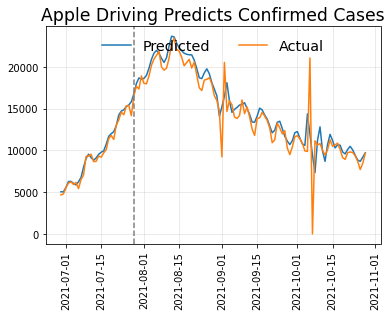

In [15]:
infect = pd.concat([y_multi_dr_i_total,
                   data.Cases_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                   axis=1)
infect.columns = ['multi_i', 'actual', 'Date']

infect.dropna(subset = ['multi_i', 'actual', 'Date'], inplace=True)


plt.plot(infect['Date'],infect['multi_i'], label = "Predicted")
plt.plot(infect['Date'],infect['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Apple Driving Predicts Confirmed Cases", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)

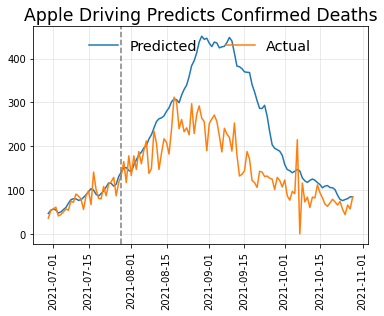

In [16]:
death = pd.concat([y_multi_dr_d_total,
                   data.Deaths_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                  axis=1)
death.columns = ['multi_d', 'actual', 'Date']

death.dropna(subset = ['multi_d', 'actual', 'Date'], inplace=True)


plt.plot(death['Date'],death['multi_d'], label = "Predicted")
plt.plot(death['Date'],death['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Apple Driving Predicts Confirmed Deaths", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


### Result Table

In [17]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Multivariate: Confirmed Cases',
                                                   'Multivariate: Confirmed Deaths'],
                                                  [multi_in, multi_de],
                                    [round(scores_multi_dr_i1[1],3), round(scores_multi_dr_d1[1],3)],
                                    [round(scores_multi_dr_i[1],3), round(scores_multi_dr_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()

## Analysis: Walking

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [ ]:
# Multivariate CNN confirmed cases

kernel = [3, 5, 7]
pool = [2]
cnn_i_multi_wk = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_i_tr_wk, y_i_tr)
    cnn_i_multi_wk.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr_wk, y_i_tr)
    cnn_i_multi_wk.append(score)

cnn_i_multi_wk = pd.DataFrame(cnn_i_multi_wk).T
cnn_i_multi_wk.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 5.259
filter = 4, kernel size = 3, pooling size = 2: 4.809
filter = 8, kernel size = 3, pooling size = 2: 5.444
filter = 16, kernel size = 3, pooling size = 2: 3.970
filter = 32, kernel size = 3, pooling size = 2: 4.019
filter = 64, kernel size = 3, pooling size = 2: 3.668
filter = 128, kernel size = 3, pooling size = 2: 3.863
filter = 256, kernel size = 3, pooling size = 2: 4.084
filter = 512, kernel size = 3, pooling size = 2: 5.267
filter = 1024, kernel size = 3, pooling size = 2: 5.618
filter = 2, kernel size = 5, pooling size = 2: 5.265
filter = 4, kernel size = 5, pooling size = 2: 4.551
filter = 8, kernel size = 5, pooling size = 2: 5.118
filter = 16, kernel size = 5, pooling size = 2: 4.979
filter = 32, kernel size = 5, pooling size = 2: 3.968
filter = 64, kernel size = 5, pooling size = 2: 4.192
filter = 128, kernel size = 5, pooling size = 2: 3.774
filter = 256, kernel size = 5, pooling size = 2: 3.971
filter = 512, kernel size =

In [ ]:
# Multivariate CNN confirmed deaths

pool = [2]
cnn_d_multi_wk = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_wk, y_d_tr)
    cnn_d_multi_wk.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_tr_wk, y_d_tr)
    cnn_d_multi_wk.append(score)

cnn_d_multi_wk = pd.DataFrame(cnn_d_multi_wk).T
cnn_d_multi_wk.columns = ['k3p2', 'k3p3','k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 11.831
filter = 4, kernel size = 3, pooling size = 2: 10.805
filter = 8, kernel size = 3, pooling size = 2: 8.917
filter = 16, kernel size = 3, pooling size = 2: 8.652
filter = 32, kernel size = 3, pooling size = 2: 6.593
filter = 64, kernel size = 3, pooling size = 2: 5.897
filter = 128, kernel size = 3, pooling size = 2: 6.127
filter = 256, kernel size = 3, pooling size = 2: 5.222
filter = 512, kernel size = 3, pooling size = 2: 4.339
filter = 1024, kernel size = 3, pooling size = 2: 4.539
filter = 2, kernel size = 5, pooling size = 2: 9.965
filter = 4, kernel size = 5, pooling size = 2: 9.245
filter = 8, kernel size = 5, pooling size = 2: 6.725
filter = 16, kernel size = 5, pooling size = 2: 8.287
filter = 32, kernel size = 5, pooling size = 2: 7.097
filter = 64, kernel size = 5, pooling size = 2: 7.762
filter = 128, kernel size = 5, pooling size = 2: 6.819
filter = 256, kernel size = 5, pooling size = 2: 6.070
filter = 512, kernel size

### LSTM

In [ ]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

units = [2, 4,8,16,32,64,128,256,512, 1024]

# Multivariate LSTM confirmed cases

lstm_i_multi_wk = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_tr_wk, y_i_tr, i)
  lstm_i_multi_wk.append(score)



# Multivariate LSTM confirmed deaths

lstm_d_multi_wk = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_tr_wk, y_d_tr, i)
  lstm_d_multi_wk.append(score)

### GRU

In [ ]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# Multivariate GRU confirmed cases

gru_i_multi_wk = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_tr_wk, y_i_tr, i)
  gru_i_multi_wk.append(score)


# Multivariate GRU confirmed deaths

gru_d_multi_wk = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_tr_wk, y_d_tr, i)
  gru_d_multi_wk.append(score)

### RNNs

In [ ]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# Multivariate RNNs confirmed cases

rnn_i_multi_wk = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_tr_wk, y_i_tr, i)
  rnn_i_multi_wk.append(score)


# Multivariate RNNs confirmed deaths

rnn_d_multi_wk = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_tr_wk, y_d_tr, i)
  rnn_d_multi_wk.append(score)

### Result Table

#### Multivariate Confirmed Cases

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', 
                                                   '32 Nodes', "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_multi_wk[0],3), 
                                     round(gru_i_multi_wk[0],3),
                                     round(rnn_i_multi_wk[0],3), 
                                     round(cnn_i_multi_wk.iloc[0,0],3),
                                     round(cnn_i_multi_wk.iloc[0,1],3),
                                     round(cnn_i_multi_wk.iloc[0,2],3),
                                     round(cnn_i_multi_wk.iloc[0,3],3),
                                     round(cnn_i_multi_wk.iloc[0,4],3),
                                     round(cnn_i_multi_wk.iloc[0,5],3)],
                                     [round(lstm_i_multi_wk[1],3), 
                                     round(gru_i_multi_wk[1],3),
                                     round(rnn_i_multi_wk[1],3), 
                                     round(cnn_i_multi_wk.iloc[1,0],3),
                                     round(cnn_i_multi_wk.iloc[1,1],3),
                                     round(cnn_i_multi_wk.iloc[1,2],3),
                                     round(cnn_i_multi_wk.iloc[1,3],3),
                                     round(cnn_i_multi_wk.iloc[1,4],3),
                                     round(cnn_i_multi_wk.iloc[1,5],3)],
                                     [round(lstm_i_multi_wk[2],3), 
                                     round(gru_i_multi_wk[2],3),
                                     round(rnn_i_multi_wk[2],3), 
                                     round(cnn_i_multi_wk.iloc[2,0],3),
                                     round(cnn_i_multi_wk.iloc[2,1],3),
                                     round(cnn_i_multi_wk.iloc[2,2],3),
                                     round(cnn_i_multi_wk.iloc[2,3],3),
                                     round(cnn_i_multi_wk.iloc[2,4],3),
                                     round(cnn_i_multi_wk.iloc[2,5],3)],
                                     [round(lstm_i_multi_wk[3],3), 
                                     round(gru_i_multi_wk[3],3),
                                     round(rnn_i_multi_wk[3],3), 
                                     round(cnn_i_multi_wk.iloc[3,0],3),
                                     round(cnn_i_multi_wk.iloc[3,1],3),
                                     round(cnn_i_multi_wk.iloc[3,2],3),
                                     round(cnn_i_multi_wk.iloc[3,3],3),
                                     round(cnn_i_multi_wk.iloc[3,4],3),
                                     round(cnn_i_multi_wk.iloc[3,5],3)],
                                     [round(lstm_i_multi_wk[4],3), 
                                     round(gru_i_multi_wk[4],3),
                                     round(rnn_i_multi_wk[4],3), 
                                     round(cnn_i_multi_wk.iloc[4,0],3),
                                     round(cnn_i_multi_wk.iloc[4,1],3),
                                     round(cnn_i_multi_wk.iloc[4,2],3),
                                     round(cnn_i_multi_wk.iloc[4,3],3),
                                     round(cnn_i_multi_wk.iloc[4,4],3),
                                     round(cnn_i_multi_wk.iloc[4,5],3)],
                                     [round(lstm_i_multi_wk[5],3), 
                                     round(gru_i_multi_wk[5],3),
                                     round(rnn_i_multi_wk[5],3), 
                                     round(cnn_i_multi_wk.iloc[5,0],3),
                                     round(cnn_i_multi_wk.iloc[5,1],3),
                                     round(cnn_i_multi_wk.iloc[5,2],3),
                                     round(cnn_i_multi_wk.iloc[5,3],3),
                                     round(cnn_i_multi_wk.iloc[5,4],3),
                                     round(cnn_i_multi_wk.iloc[5,5],3)],
                                     [round(lstm_i_multi_wk[6],3), 
                                     round(gru_i_multi_wk[6],3),
                                     round(rnn_i_multi_wk[6],3), 
                                     round(cnn_i_multi_wk.iloc[6,0],3),
                                     round(cnn_i_multi_wk.iloc[6,1],3),
                                     round(cnn_i_multi_wk.iloc[6,2],3),
                                     round(cnn_i_multi_wk.iloc[6,3],3),
                                     round(cnn_i_multi_wk.iloc[6,4],3),
                                     round(cnn_i_multi_wk.iloc[6,5],3)],
                                     [round(lstm_i_multi_wk[7],3), 
                                     round(gru_i_multi_wk[7],3),
                                     round(rnn_i_multi_wk[7],3), 
                                     round(cnn_i_multi_wk.iloc[7,0],3),
                                     round(cnn_i_multi_wk.iloc[7,1],3),
                                     round(cnn_i_multi_wk.iloc[7,2],3),
                                     round(cnn_i_multi_wk.iloc[7,3],3),
                                     round(cnn_i_multi_wk.iloc[7,4],3),
                                     round(cnn_i_multi_wk.iloc[7,5],3)],
                                     [round(lstm_i_multi_wk[8],3), 
                                     round(gru_i_multi_wk[8],3),
                                     round(rnn_i_multi_wk[8],3), 
                                     round(cnn_i_multi_wk.iloc[8,0],3),
                                     round(cnn_i_multi_wk.iloc[8,1],3),
                                     round(cnn_i_multi_wk.iloc[8,2],3),
                                     round(cnn_i_multi_wk.iloc[8,3],3),
                                     round(cnn_i_multi_wk.iloc[8,4],3),
                                     round(cnn_i_multi_wk.iloc[8,5],3)],
                                     [round(lstm_i_multi_wk[9],3), 
                                     round(gru_i_multi_wk[9],3),
                                     round(rnn_i_multi_wk[9],3), 
                                     round(cnn_i_multi_wk.iloc[9,0],3),
                                     round(cnn_i_multi_wk.iloc[9,1],3),
                                     round(cnn_i_multi_wk.iloc[9,2],3),
                                     round(cnn_i_multi_wk.iloc[9,3],3),
                                     round(cnn_i_multi_wk.iloc[9,4],3),
                                     round(cnn_i_multi_wk.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Multivariate Confirmed Deaths

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes' , '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_multi_wk[0],3), 
                                     round(gru_d_multi_wk[0],3),
                                     round(rnn_d_multi_wk[0],3), 
                                     round(cnn_d_multi_wk.iloc[0,0],3),
                                     round(cnn_d_multi_wk.iloc[0,1],3),
                                     round(cnn_d_multi_wk.iloc[0,2],3),
                                     round(cnn_d_multi_wk.iloc[0,3],3),
                                     round(cnn_d_multi_wk.iloc[0,4],3),
                                     round(cnn_d_multi_wk.iloc[0,5],3)],
                                     [round(lstm_d_multi_wk[1],3), 
                                     round(gru_d_multi_wk[1],3),
                                     round(rnn_d_multi_wk[1],3), 
                                     round(cnn_d_multi_wk.iloc[1,0],3),
                                     round(cnn_d_multi_wk.iloc[1,1],3),
                                     round(cnn_d_multi_wk.iloc[1,2],3),
                                     round(cnn_d_multi_wk.iloc[1,3],3),
                                     round(cnn_d_multi_wk.iloc[1,4],3),
                                     round(cnn_d_multi_wk.iloc[1,5],3)],
                                     [round(lstm_d_multi_wk[2],3), 
                                     round(gru_d_multi_wk[2],3),
                                     round(rnn_d_multi_wk[2],3), 
                                     round(cnn_d_multi_wk.iloc[2,0],3),
                                     round(cnn_d_multi_wk.iloc[2,1],3),
                                     round(cnn_d_multi_wk.iloc[2,2],3),
                                     round(cnn_d_multi_wk.iloc[2,3],3),
                                     round(cnn_d_multi_wk.iloc[2,4],3),
                                     round(cnn_d_multi_wk.iloc[2,5],3)],
                                     [round(lstm_d_multi_wk[3],3), 
                                     round(gru_d_multi_wk[3],3),
                                     round(rnn_d_multi_wk[3],3), 
                                     round(cnn_d_multi_wk.iloc[3,0],3),
                                     round(cnn_d_multi_wk.iloc[3,1],3),
                                     round(cnn_d_multi_wk.iloc[3,2],3),
                                     round(cnn_d_multi_wk.iloc[3,3],3),
                                     round(cnn_d_multi_wk.iloc[3,4],3),
                                     round(cnn_d_multi_wk.iloc[3,5],3)],
                                     [round(lstm_d_multi_wk[4],3), 
                                     round(gru_d_multi_wk[4],3),
                                     round(rnn_d_multi_wk[4],3), 
                                     round(cnn_d_multi_wk.iloc[4,0],3),
                                     round(cnn_d_multi_wk.iloc[4,1],3),
                                     round(cnn_d_multi_wk.iloc[4,2],3),
                                     round(cnn_d_multi_wk.iloc[4,3],3),
                                     round(cnn_d_multi_wk.iloc[4,4],3),
                                     round(cnn_d_multi_wk.iloc[4,5],3)],
                                     [round(lstm_d_multi_wk[5],3), 
                                     round(gru_d_multi_wk[5],3),
                                     round(rnn_d_multi_wk[5],3), 
                                     round(cnn_d_multi_wk.iloc[5,0],3),
                                     round(cnn_d_multi_wk.iloc[5,1],3),
                                     round(cnn_d_multi_wk.iloc[5,2],3),
                                     round(cnn_d_multi_wk.iloc[5,3],3),
                                     round(cnn_d_multi_wk.iloc[5,4],3),
                                     round(cnn_d_multi_wk.iloc[5,5],3)],
                                     [round(lstm_d_multi_wk[6],3), 
                                     round(gru_d_multi_wk[6],3),
                                     round(rnn_d_multi_wk[6],3), 
                                     round(cnn_d_multi_wk.iloc[6,0],3),
                                     round(cnn_d_multi_wk.iloc[6,1],3),
                                     round(cnn_d_multi_wk.iloc[6,2],3),
                                     round(cnn_d_multi_wk.iloc[6,3],3),
                                     round(cnn_d_multi_wk.iloc[6,4],3),
                                     round(cnn_d_multi_wk.iloc[6,5],3)],
                                     [round(lstm_d_multi_wk[7],3), 
                                     round(gru_d_multi_wk[7],3),
                                     round(rnn_d_multi_wk[7],3), 
                                     round(cnn_d_multi_wk.iloc[7,0],3),
                                     round(cnn_d_multi_wk.iloc[7,1],3),
                                     round(cnn_d_multi_wk.iloc[7,2],3),
                                     round(cnn_d_multi_wk.iloc[7,3],3),
                                     round(cnn_d_multi_wk.iloc[7,4],3),
                                     round(cnn_d_multi_wk.iloc[7,5],3)],
                                     [round(lstm_d_multi_wk[8],3), 
                                     round(gru_d_multi_wk[8],3),
                                     round(rnn_d_multi_wk[8],3), 
                                     round(cnn_d_multi_wk.iloc[8,0],3),
                                     round(cnn_d_multi_wk.iloc[8,1],3),
                                     round(cnn_d_multi_wk.iloc[8,2],3),
                                     round(cnn_d_multi_wk.iloc[8,3],3),
                                     round(cnn_d_multi_wk.iloc[8,4],3),
                                     round(cnn_d_multi_wk.iloc[8,5],3)],
                                     [round(lstm_d_multi_wk[9],3), 
                                     round(gru_d_multi_wk[9],3),
                                     round(rnn_d_multi_wk[9],3), 
                                     round(cnn_d_multi_wk.iloc[9,0],3),
                                     round(cnn_d_multi_wk.iloc[9,1],3),
                                     round(cnn_d_multi_wk.iloc[9,2],3),
                                     round(cnn_d_multi_wk.iloc[9,3],3),
                                     round(cnn_d_multi_wk.iloc[9,4],3),
                                     round(cnn_d_multi_wk.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right','right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Multivariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Training and Validation: Walking

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Multivariate Confirmed Cases

In [18]:
seed(1)
tensorflow.random.set_seed(1)

# model_multi_wk_i = Sequential()
# model_multi_wk_i.add(Conv1D(filters = 1024, kernel_size = 5, activation='relu', input_shape=(X_i_tr.shape[1], X_i_tr.shape[2])))
# # model_multi_wk_i.add(MaxPooling1D(pool_size = 2))
# model_multi_wk_i.add(Flatten())
# # model_multi_wk_i.add(Dense(64, activation = "relu"))
# model_multi_wk_i.add(Dense(1, activation = "linear"))
# model_multi_wk_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_multi_wk_i = Sequential()
model_multi_wk_i.add(LSTM(32, activation='relu', input_shape=(X_i_tr_wk.shape[1], X_i_tr_wk.shape[2])))
# model_multi_wk_i.add(Dense(2, activation = "relu"))
model_multi_wk_i.add(Dense(1, activation = "linear"))
model_multi_wk_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_wk_i.fit(X_i_tr_wk, y_i_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)


scores_multi_wk_i1 = model_multi_wk_i.evaluate(X_i_tr_wk, y_i_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_wk_i1[1])

scores_multi_wk_i = model_multi_wk_i.evaluate(X_i_ts_wk, y_i_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_wk_i[1])

MAPE: training =  4.531622409820557
MAPE: test =  48.795528411865234


In [19]:
# make a prediction
# training set
y_multi_wk_i_tr = pd.DataFrame(model_multi_wk_i.predict(X_i_tr_wk))

# test set
y_multi_wk_i_ts = pd.DataFrame(model_multi_wk_i.predict(X_i_ts_wk))

# combine training and test predictions
y_multi_wk_i_total = pd.concat([y_multi_wk_i_tr, y_multi_wk_i_ts], ignore_index=True)


### Multivariate Confirmed Deaths

In [20]:
seed(1)
tensorflow.random.set_seed(1)

model_multi_wk_d = Sequential()
model_multi_wk_d.add(GRU(256, activation = 'relu', input_shape=(X_d_tr_wk.shape[1], X_d_tr_wk.shape[2])))
# model_multi_wk_d.add(Dense(2, activation = "relu"))
model_multi_wk_d.add(Dense(1, activation = "linear"))
model_multi_wk_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# model_multi_wk_d = Sequential()
# model_multi_wk_d.add(Conv1D(1024, kernel_size = 3, activation = 'relu', input_shape=(X_d_tr.shape[1], X_d_tr.shape[2])))
# model_multi_wk_d.add(MaxPooling1D(3))
# model_multi_wk_d.add(Flatten())
# # model_multi_wk_d.add(Dense(4, activation = "relu"))
# model_multi_wk_d.add(Dense(1, activation = "linear"))
# model_multi_wk_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_multi_wk_d.fit(X_d_tr_wk, y_d_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_multi_wk_d1 = model_multi_wk_d.evaluate(X_d_tr_wk, y_d_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_multi_wk_d1[1])

scores_multi_wk_d = model_multi_wk_d.evaluate(X_d_ts_wk, y_d_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_multi_wk_d[1])

MAPE: training =  5.8008809089660645
MAPE: test =  41.28771209716797


In [21]:
# make a prediction
# training set
y_multi_wk_d_tr = pd.DataFrame(model_multi_wk_d.predict(X_d_tr_wk))

# test set
y_multi_wk_d_ts = pd.DataFrame(model_multi_wk_d.predict(X_d_ts_wk))

# combine training and test predictions
y_multi_wk_d_total = pd.concat([y_multi_wk_d_tr, y_multi_wk_d_ts], ignore_index=True)


In [22]:

multi_in = "LSTM"
multi_de = "GRU"
tick_spacing = 5
date_test = data['Date'][0+index+lag-1]

### Plots

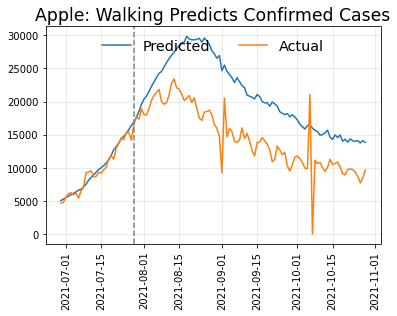

In [23]:
infect = pd.concat([y_multi_wk_i_total,
                   data.Cases_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                   axis=1)
infect.columns = ['multi_i', 'actual', 'Date']

infect.dropna(subset = ['multi_i', 'actual', 'Date'], inplace=True)


plt.plot(infect['Date'],infect['multi_i'], label = "Predicted")
plt.plot(infect['Date'],infect['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Apple: Walking Predicts Confirmed Cases", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)

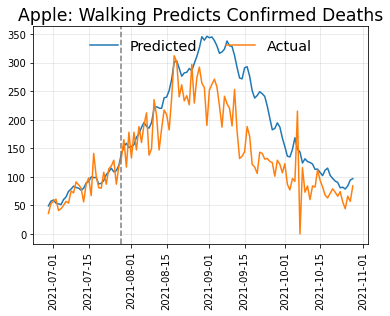

In [24]:
death = pd.concat([y_multi_wk_d_total,
                   data.Deaths_daily.iloc[lag:].reset_index(drop = True), 
                   data.Date.iloc[lag:].reset_index(drop = True)],
                  axis=1)
death.columns = ['multi_d', 'actual', 'Date']

death.dropna(subset = ['multi_d', 'actual', 'Date'], inplace=True)


plt.plot(death['Date'],death['multi_d'], label = "Predicted")
plt.plot(death['Date'],death['actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Apple: Walking Predicts Confirmed Deaths", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


### Result Table

In [25]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Multivariate: Confirmed Cases',
                                                   'Multivariate: Confirmed Deaths'],
                                                  [multi_in, multi_de],
                                    [round(scores_multi_wk_i1[1],3), round(scores_multi_wk_d1[1],3)],
                                    [round(scores_multi_wk_i[1],3), round(scores_multi_wk_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()